# Explore DO Outliers

In [20]:
# imports
import os
import xarray
from importlib import reload

import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

import pandas

from siosandbox.cugn import oxygen
from siosandbox.cugn import stats
from siosandbox.cugn import figures
from siosandbox.cugn import space_time

# Load the data

In [5]:
data_path = os.getenv('CUGN')
datafile = 'CUGN_potential_line_90.nc'
ds = xarray.load_dataset(os.path.join(data_path, datafile))

# Generate the grid

In [6]:
mean_oxyT, xedges, yedges, countsT, \
    grid_indices, gd_oxy, da_gd = oxygen.gen_map(ds, stat='mean')


# Outliers (<5%)

In [66]:
reload(stats)
pcut = 5.
outliers, rowcol = stats.find_outliers(gd_oxy, grid_indices, countsT, pcut, da_gd)

times = pandas.to_datetime(ds.time[outliers[:,1]])
months = times.month.values.astype(int)

lons = ds.lon[outliers[:,1]].values

# Density, AS
sigma_o = ds.sigma0.data[(outliers[:,0], outliers[:,1])]
SA_o = ds.SA.data[(outliers[:,0], outliers[:,1])]
DO_o = ds.doxy.data[(outliers[:,0], outliers[:,1])]

# Grab an example -- 2017 at low density and low longitude

In [26]:
idx_o = (times.year==2017) & (lons < -121.) & (sigma_o < 25.5)

In [27]:
np.sum(idx_o)

245

## Show in TS space

/tmp/ipykernel_349916/1292841672.py:2: RuntimeWarning: divide by zero encountered in log10
  ax = figures.show_grid(xedges, yedges, np.log10(countsT),


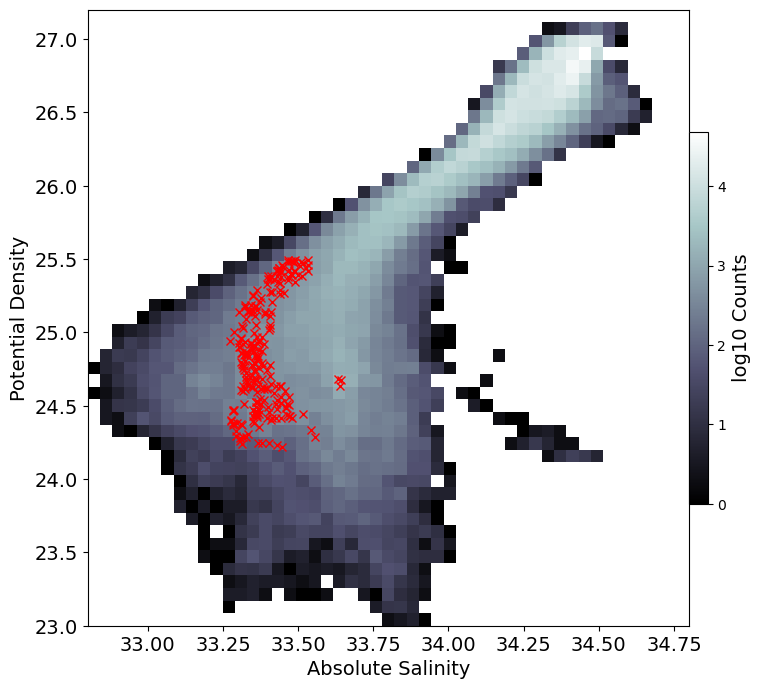

In [30]:
reload(figures)
ax = figures.show_grid(xedges, yedges, np.log10(countsT),
              ('Absolute Salinity', 'Potential Density'),
              r'log10 Counts',
                 cmap='bone', show=False) 
                 #vmnx=(-3,0.))
# Add on outliers
ax.plot(SA_o[idx_o], sigma_o[idx_o], 'rx')
plt.show()

## DO distribution

### Find values in row,col

#### Find unique row, col

In [50]:
all_row_col = np.array([col*10000 + row for row,col in rowcol])
# Cut on year, etc.
sub_row_col = all_row_col[idx_o]
uni_rc = np.unique(sub_row_col)
# 
#uni_rc.size
sub_col = uni_rc // 10000
sub_row = uni_rc - sub_col*10000

In [51]:
sub_row

array([12, 13, 14, 15, 12, 13, 18, 11, 12, 13, 14, 15, 16, 17, 11, 12, 13,
       14, 15, 16, 12, 13, 14, 15, 16, 12, 13, 14, 15, 20, 12, 13, 14, 12,
       13, 14, 11, 12, 13, 14, 11, 12, 13, 14, 12, 13, 14, 12, 13, 14, 15,
       13, 14, 15, 14, 15, 16, 17, 15, 16, 17, 16, 17])

In [55]:
yedges[sub_col].min()

24.2

In [71]:
all_vals = []
for row, col in zip(sub_row, sub_col):
    # Get indices
    in_cell = (grid_indices[0] == row+1) & (grid_indices[1] == col+1)
    idx_cell = np.where(in_cell)[0]

    vals = gd_oxy[idx_cell]
    all_vals += vals.tolist()
#
all_vals = np.array(all_vals)

## Plot me

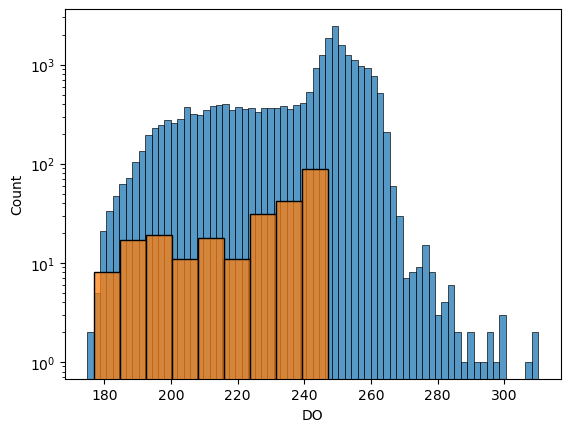

In [75]:
plt.clf()
ax = plt.gca()
#
sns.histplot(all_vals, ax=ax, log_scale=(False,True))
sns.histplot(DO_o[idx_o], ax=ax)
#
ax.set_xlabel('DO')
#
plt.show()